![OpenSARlab notebook banner](NotebookAddons/blackboard-banner.png)

# Prepare a SAR Data Stack
### Joseph H Kennedy and Alex Lewandowski; Alaska Satellite Facility

This notebook downloads an ASF-HyP3 RTC project and prepares a deep multi-temporal SAR image data stack for use in other notebooks.

<img style="padding: 7px" src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right"/></font>

### Important Note about JupyterHub

**Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.**

In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)


URLWidget()

In [2]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/rtc_analysis':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "rtc_analysis" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select the "rtc_analysis" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "rtc_analysis" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))

## 0. Importing Relevant Python Packages

In this notebook we will use the following scientific libraries:

1. [GDAL](https://www.gdal.org/) is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.
1. [NumPy](http://www.numpy.org/) is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays and matrices, and an extensive collection of high-level mathematical functions and implemented methods makes it possible to perform various operations with these objects.

**Our first step is to import them:**

In [3]:
%%capture
import copy
from datetime import datetime, timedelta, timezone
import json # for loads
from pathlib import Path
import re
import shutil
import warnings
import rasterio
from rasterio.merge import merge

from osgeo import gdal
import numpy as np

from IPython.display import display, clear_output, Markdown

import opensarlab_lib as asfn

from hyp3_sdk import Batch, HyP3

## 1. Load Your Own Data Stack Into the Notebook

This notebook assumes that you've created your own data stack over your personal area of interest using the [Alaska Satellite Facility's](https://www.asf.alaska.edu/) value-added product system HyP3, available via [ASF Data Search (Vertex)](https://search.asf.alaska.edu/#/). HyP3 is an ASF service used to prototype value added products and provide them to users to collect feedback.

We will retrieve HyP3 data via the hyp3_sdk. As both HyP3 and the Notebook environment sit in the [Amazon Web Services (AWS)](https://aws.amazon.com/) cloud, data transfer is quick and cost effective.

---

Before we download anything, create a working directory for this analysis.

**Select or create a working directory for the analysis:**

In [4]:
while True:
    print(f"Current working directory: {Path.cwd()}")
    data_dir = Path(Path.cwd()/'Dataset'/input(f"\nPlease enter the name of a directory in which to store your data for this analysis."))
    if data_dir == Path('.'):
        continue
    if data_dir.is_dir():
        contents = data_dir.glob('*')
        if len(list(contents)) > 0:
            choice = asfn.handle_old_data(data_dir)
            if choice == 1:
                if data_dir.exists():
                    shutil.rmtree(data_dir)
                data_dir.mkdir(parents=True, exist_ok=True)
                break
            elif choice == 2:
                break
            else:
                clear_output()
                continue
        else:
            break
    else:
        data_dir.mkdir(parents=True, exist_ok=True)
        break

Current working directory: /home/jovyan/Hydrosar



Please enter the name of a directory in which to store your data for this analysis. Tripura


**Define absolute path to  analysis directory:**

In [5]:
analysis_directory = Path.cwd().joinpath(data_dir)
print(f"analysis_directory: {analysis_directory}")

analysis_directory: /home/jovyan/Hydrosar/Dataset/Tripura


**Create a HyP3 object and authenticate:**

In [6]:
hyp3 = HyP3(prompt=True)

NASA Earthdata Login username:  vdevauxchupin
NASA Earthdata Login password:  ········


**Select a product type to download:**

In [7]:
job_types = ['RTC_GAMMA', 'INSAR_GAMMA', 'AUTORIFT']
job_type = asfn.select_parameter(job_types)
job_type

RadioButtons(layout=Layout(min_width='800px'), options=('RTC_GAMMA', 'INSAR_GAMMA', 'AUTORIFT'), value='RTC_GA…

**Decide whether to search for a HyP3 project or jobs unattached to a project:** 

In [8]:
options = ['project', 'projectless jobs']
search_type = asfn.select_parameter(options, '')
print("Select whether to search for HyP3 Project or HyP3 Jobs unattached to a project")
display(search_type)

Select whether to search for HyP3 Project or HyP3 Jobs unattached to a project


RadioButtons(layout=Layout(min_width='800px'), options=('project', 'projectless jobs'), value='project')

**List projects containing active products of the type chosen in the previous cell and select one:**

In [9]:
my_hyp3_info = hyp3.my_info()
active_projects = dict()

if search_type.value == 'project':
    for project in my_hyp3_info['job_names']:
        batch = Batch()
        batch = hyp3.find_jobs(name=project, job_type=job_type.value).filter_jobs(running=False, include_expired=False)
        if len(batch) > 0:
            active_projects.update({batch.jobs[0].name: batch})

    if len(active_projects) > 0:
        display(Markdown("<text style='color:darkred;'>Note: After selecting a project, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
        display(Markdown("<text style='color:darkred;'>Otherwise, you will rerun this code cell.</text>"))
        print('\nSelect a Project:')
        project_select = asfn.select_parameter(active_projects.keys())
        display(project_select)
if search_type.value == 'projectless jobs' or len(active_projects) == 0:
    project_select = False
    if search_type.value == 'project':
        print(f"There were no {job_type.value} jobs found in any current projects.\n")
    jobs = hyp3.find_jobs(job_type=job_type.value).filter_jobs(running=False, include_expired=False)
    orphaned_jobs = Batch()
    for j in jobs:
        if not j.name:
            orphaned_jobs += j
    jobs = orphaned_jobs

    if len(jobs) > 0:
        print(f"Found {len(jobs)} {job_type.value} jobs that are not part of a project.")
        print(f"Select the jobs you wish to download")
        jobs = {i.files[0]['filename']: i for i in jobs}
        jobs_select = asfn.select_mult_parameters(jobs.keys(), '', width='500px')
        display(jobs_select)
    else:
        print(f"There were no {job_type.value} jobs found that are not part of a project either.")
    

<text style='color:darkred;'>Note: After selecting a project, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you will rerun this code cell.</text>


Select a Project:


RadioButtons(layout=Layout(min_width='800px'), options=('Tripura_July',), value='Tripura_July')


**Select a date range of products to download:**

In [10]:
if project_select:
    batch = active_projects[project_select.value]
else:
    batch = Batch()
    for j in jobs_select.value:
        batch += jobs[j]

display(Markdown("<text style='color:darkred;'>Note: After selecting a date range, you should select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
display(Markdown("<text style='color:darkred;'>Otherwise, you may simply rerun this code cell.</text>"))
print('\nSelect a Date Range:')
dates = asfn.get_job_dates(batch)
date_picker = asfn.gui_date_picker(dates)
date_picker

<text style='color:darkred;'>Note: After selecting a date range, you should select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you may simply rerun this code cell.</text>


Select a Date Range:


SelectionRangeSlider(description='Dates', index=(0, 804), layout=Layout(width='500px'), options=((' 10/11/2017…

**Save the selected date range and remove products falling outside of it:**

In [11]:
date_range = asfn.get_slider_vals(date_picker)
date_range[0] = date_range[0].date()
date_range[1] = date_range[1].date()
print(f"Date Range: {str(date_range[0])} to {str(date_range[1])}")
batch = asfn.filter_jobs_by_date(batch, date_range)

Date Range: 2017-10-11 to 2019-12-24


**Gather the available paths and orbit directions for the remaining products:**

In [12]:
display(Markdown("<text style='color:darkred;'><text style='font-size:150%;'>This may take some time for projects containing many jobs...</text></text>"))
asfn.set_paths_orbits(batch)
paths = set()
orbit_directions = set()
for p in batch:
    paths.add(p.path)
    orbit_directions.add(p.orbit_direction)
paths.add('All Paths')
display(Markdown(f"<text style=color:blue><text style='font-size:175%;'>Done.</text></text>"))

<text style='color:darkred;'><text style='font-size:150%;'>This may take some time for projects containing many jobs...</text></text>

<text style=color:blue><text style='font-size:175%;'>Done.</text></text>

---
**Select a path or paths (use shift or ctrl to select multiple paths):**

In [13]:
display(Markdown("<text style='color:darkred;'>Note: After selecting a path, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
display(Markdown("<text style='color:darkred;'>Otherwise, you will simply rerun this code cell.</text>"))
print('\nSelect a Path:')
path_choice = asfn.select_mult_parameters(paths)
path_choice

<text style='color:darkred;'>Note: After selecting a path, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>

<text style='color:darkred;'>Otherwise, you will simply rerun this code cell.</text>


Select a Path:


SelectMultiple(layout=Layout(height='38px', width='175px'), options=('All Paths', 150), value=())

**Save the selected flight path/s:**

In [14]:
flight_path = path_choice.value
if flight_path:
    if flight_path:
        print(f"Flight Path: {flight_path}")
    else:
        print('Flight Path: All Paths')
else:
    print("WARNING: You must select a flight path in the previous cell, then rerun this cell.")

Flight Path: ('All Paths',)


**Select an orbit direction:**

In [15]:
if len(orbit_directions) > 1:
    display(Markdown("<text style='color:red;'>Note: After selecting a flight direction, you must select the next cell before hitting the 'Run' button or typing Shift/Enter.</text>"))
    display(Markdown("<text style='color:red;'>Otherwise, you will simply rerun this code cell.</text>"))
print('\nSelect a Flight Direction:')
direction_choice = asfn.select_parameter(orbit_directions, 'Direction:')
direction_choice


Select a Flight Direction:


RadioButtons(description='Direction:', layout=Layout(min_width='800px'), options=('DESCENDING',), value='DESCE…

**Save the selected orbit direction:**

In [16]:
direction = direction_choice.value
print(f"Orbit Direction: {direction}")

Orbit Direction: DESCENDING


**Filter jobs by path and orbit direction:**

In [17]:
batch = asfn.filter_jobs_by_path(batch, flight_path)
batch = asfn.filter_jobs_by_orbit(batch, direction)
print(f"There are {len(batch)} products to download.")

There are 63 products to download.


**Download the products, unzip them into a directory named after the product type, and delete the zip files:**

In [18]:
products_path = analysis_directory.joinpath(job_type.value)
print(products_path)
if not products_path.is_dir():
    products_path.mkdir()

print(f"\nProject: {batch.jobs[0].name}")
project_zips = batch.download_files(products_path)
for z in project_zips:
    if z.suffix == '.nc':
        continue
    
    asfn.asf_unzip(str(products_path), str(z))
    z.unlink()

/home/jovyan/Hydrosar/Dataset/Tripura/RTC_GAMMA

Project: Tripura_July


  0%|          | 0/63 [00:00<?, ?it/s]

S1A_IW_20180103T235531_DVP_RTC30_G_gpufem_31C0.zip:   0%|          | 0/505603764 [00:00<?, ?it/s]

S1A_IW_20171104T235534_DVP_RTC30_G_gpufem_A2FD.zip:   0%|          | 0/501386553 [00:00<?, ?it/s]

S1A_IW_20171128T235533_DVP_RTC30_G_gpufem_06F8.zip:   0%|          | 0/503154068 [00:00<?, ?it/s]

S1A_IW_20180421T235532_DVP_RTC30_G_gpufem_FE2B.zip:   0%|          | 0/502192560 [00:00<?, ?it/s]

S1A_IW_20180714T235536_DVP_RTC30_G_gpufem_AB5F.zip:   0%|          | 0/503115500 [00:00<?, ?it/s]

S1A_IW_20180127T235531_DVP_RTC30_G_gpufem_EBAD.zip:   0%|          | 0/508199695 [00:00<?, ?it/s]

S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56.zip:   0%|          | 0/501053172 [00:00<?, ?it/s]

S1A_IW_20171210T235533_DVP_RTC30_G_gpufem_5750.zip:   0%|          | 0/501142474 [00:00<?, ?it/s]

S1A_IW_20180515T235533_DVP_RTC30_G_gpufem_7E28.zip:   0%|          | 0/500702794 [00:00<?, ?it/s]

S1A_IW_20180316T235531_DVP_RTC30_G_gpufem_2E6F.zip:   0%|          | 0/504123562 [00:00<?, ?it/s]

S1A_IW_20180220T235530_DVP_RTC30_G_gpufem_7CEE.zip:   0%|          | 0/507253925 [00:00<?, ?it/s]

S1A_IW_20180608T235534_DVP_RTC30_G_gpufem_7207.zip:   0%|          | 0/500594030 [00:00<?, ?it/s]

S1A_IW_20171222T235532_DVP_RTC30_G_gpufem_E7A6.zip:   0%|          | 0/503520647 [00:00<?, ?it/s]

S1A_IW_20171023T235534_DVP_RTC30_G_gpufem_32DC.zip:   0%|          | 0/502167133 [00:00<?, ?it/s]

S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1.zip:   0%|          | 0/506338917 [00:00<?, ?it/s]

S1A_IW_20180409T235531_DVP_RTC30_G_gpufem_A225.zip:   0%|          | 0/503080689 [00:00<?, ?it/s]

S1A_IW_20180304T235530_DVP_RTC30_G_gpufem_7F99.zip:   0%|          | 0/503359265 [00:00<?, ?it/s]

S1A_IW_20180328T235531_DVP_RTC30_G_gpufem_EC7D.zip:   0%|          | 0/504526321 [00:00<?, ?it/s]

S1A_IW_20180208T235531_DVP_RTC30_G_gpufem_B75A.zip:   0%|          | 0/509033660 [00:00<?, ?it/s]

S1A_IW_20171011T235534_DVP_RTC30_G_gpufem_4D15.zip:   0%|          | 0/504010496 [00:00<?, ?it/s]

S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0.zip:   0%|          | 0/506221240 [00:00<?, ?it/s]

S1A_IW_20180503T235532_DVP_RTC30_G_gpufem_CE6F.zip:   0%|          | 0/499616074 [00:00<?, ?it/s]

S1A_IW_20180527T235534_DVP_RTC30_G_gpufem_AAD1.zip:   0%|          | 0/500477944 [00:00<?, ?it/s]

S1A_IW_20190323T235537_DVP_RTC30_G_gpufem_7A43.zip:   0%|          | 0/505229359 [00:00<?, ?it/s]

S1A_IW_20180819T235538_DVP_RTC30_G_gpufem_87A6.zip:   0%|          | 0/506803432 [00:00<?, ?it/s]

S1A_IW_20181018T235540_DVP_RTC30_G_gpufem_E189.zip:   0%|          | 0/505100029 [00:00<?, ?it/s]

S1A_IW_20190122T235538_DVP_RTC30_G_gpufem_D295.zip:   0%|          | 0/508809783 [00:00<?, ?it/s]

S1A_IW_20180924T235540_DVP_RTC30_G_gpufem_3FDD.zip:   0%|          | 0/505089143 [00:00<?, ?it/s]

S1A_IW_20180807T235538_DVP_RTC30_G_gpufem_ED14.zip:   0%|          | 0/509240909 [00:00<?, ?it/s]

S1A_IW_20181006T235540_DVP_RTC30_G_gpufem_C8B5.zip:   0%|          | 0/505586352 [00:00<?, ?it/s]

S1A_IW_20181111T235540_DVP_RTC30_G_gpufem_6153.zip:   0%|          | 0/504841642 [00:00<?, ?it/s]

S1A_IW_20180912T235540_DVP_RTC30_G_gpufem_F5A0.zip:   0%|          | 0/506599421 [00:00<?, ?it/s]

S1A_IW_20190203T235537_DVP_RTC30_G_gpufem_476E.zip:   0%|          | 0/509359568 [00:00<?, ?it/s]

S1A_IW_20190110T235538_DVP_RTC30_G_gpufem_98BE.zip:   0%|          | 0/507964186 [00:00<?, ?it/s]

S1A_IW_20190227T235537_DVP_RTC30_G_gpufem_A66D.zip:   0%|          | 0/506256517 [00:00<?, ?it/s]

S1A_IW_20190311T235537_DVP_RTC30_G_gpufem_C916.zip:   0%|          | 0/503440709 [00:00<?, ?it/s]

S1A_IW_20190215T235537_DVP_RTC30_G_gpufem_ECE2.zip:   0%|          | 0/508514769 [00:00<?, ?it/s]

S1A_IW_20181217T235539_DVP_RTC30_G_gpufem_6610.zip:   0%|          | 0/502851440 [00:00<?, ?it/s]

S1A_IW_20190404T235537_DVP_RTC30_G_gpufem_D032.zip:   0%|          | 0/504077894 [00:00<?, ?it/s]

S1A_IW_20181123T235540_DVP_RTC30_G_gpufem_488B.zip:   0%|          | 0/505870466 [00:00<?, ?it/s]

S1A_IW_20180831T235539_DVP_RTC30_G_gpufem_6154.zip:   0%|          | 0/504717374 [00:00<?, ?it/s]

S1A_IW_20181229T235539_DVP_RTC30_G_gpufem_9708.zip:   0%|          | 0/507286198 [00:00<?, ?it/s]

S1A_IW_20181030T235540_DVP_RTC30_G_gpufem_D12E.zip:   0%|          | 0/504943528 [00:00<?, ?it/s]

S1A_IW_20190627T235541_DVP_RTC30_G_gpufem_1281.zip:   0%|          | 0/499996652 [00:00<?, ?it/s]

S1A_IW_20190510T235539_DVP_RTC30_G_gpufem_9006.zip:   0%|          | 0/501660518 [00:00<?, ?it/s]

S1A_IW_20191001T235547_DVP_RTC30_G_gpufem_CB70.zip:   0%|          | 0/506624641 [00:00<?, ?it/s]

S1A_IW_20191224T235545_DVP_RTC30_G_gpufem_6C06.zip:   0%|          | 0/505559270 [00:00<?, ?it/s]

S1A_IW_20190709T235542_DVP_RTC30_G_gpufem_5565.zip:   0%|          | 0/504362507 [00:00<?, ?it/s]

S1A_IW_20191212T235546_DVP_RTC30_G_gpufem_663B.zip:   0%|          | 0/505976106 [00:00<?, ?it/s]

S1A_IW_20190721T235543_DVP_RTC30_G_gpufem_4653.zip:   0%|          | 0/509941683 [00:00<?, ?it/s]

S1A_IW_20190428T235538_DVP_RTC30_G_gpufem_5562.zip:   0%|          | 0/503153424 [00:00<?, ?it/s]

S1A_IW_20190802T235544_DVP_RTC30_G_gpufem_7083.zip:   0%|          | 0/510052624 [00:00<?, ?it/s]

S1A_IW_20191118T235546_DVP_RTC30_G_gpufem_7D3E.zip:   0%|          | 0/502805955 [00:00<?, ?it/s]

S1A_IW_20191130T235546_DVP_RTC30_G_gpufem_76E8.zip:   0%|          | 0/504016237 [00:00<?, ?it/s]

S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7.zip:   0%|          | 0/505922263 [00:00<?, ?it/s]

S1A_IW_20191025T235547_DVP_RTC30_G_gpufem_D0BC.zip:   0%|          | 0/503819770 [00:00<?, ?it/s]

S1A_IW_20190416T235538_DVP_RTC30_G_gpufem_979C.zip:   0%|          | 0/502975279 [00:00<?, ?it/s]

S1A_IW_20191106T235547_DVP_RTC30_G_gpufem_DFC5.zip:   0%|          | 0/502248163 [00:00<?, ?it/s]

S1A_IW_20190615T235540_DVP_RTC30_G_gpufem_B3E2.zip:   0%|          | 0/499945760 [00:00<?, ?it/s]

S1A_IW_20190826T235545_DVP_RTC30_G_gpufem_07ED.zip:   0%|          | 0/505994684 [00:00<?, ?it/s]

S1A_IW_20190603T235540_DVP_RTC30_G_gpufem_098F.zip:   0%|          | 0/502183014 [00:00<?, ?it/s]

S1A_IW_20191013T235547_DVP_RTC30_G_gpufem_9878.zip:   0%|          | 0/505523441 [00:00<?, ?it/s]

S1A_IW_20190907T235546_DVP_RTC30_G_gpufem_183C.zip:   0%|          | 0/505172202 [00:00<?, ?it/s]

Extracting: /home/jovyan/Hydrosar/Dataset/Tripura/RTC_GAMMA/S1A_IW_20180103T235531_DVP_RTC30_G_gpufem_31C0.zip
Extracting: /home/jovyan/Hydrosar/Dataset/Tripura/RTC_GAMMA/S1A_IW_20171104T235534_DVP_RTC30_G_gpufem_A2FD.zip
Extracting: /home/jovyan/Hydrosar/Dataset/Tripura/RTC_GAMMA/S1A_IW_20171128T235533_DVP_RTC30_G_gpufem_06F8.zip
Extracting: /home/jovyan/Hydrosar/Dataset/Tripura/RTC_GAMMA/S1A_IW_20180421T235532_DVP_RTC30_G_gpufem_FE2B.zip
Extracting: /home/jovyan/Hydrosar/Dataset/Tripura/RTC_GAMMA/S1A_IW_20180714T235536_DVP_RTC30_G_gpufem_AB5F.zip
Extracting: /home/jovyan/Hydrosar/Dataset/Tripura/RTC_GAMMA/S1A_IW_20180127T235531_DVP_RTC30_G_gpufem_EBAD.zip
Extracting: /home/jovyan/Hydrosar/Dataset/Tripura/RTC_GAMMA/S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56.zip
Extracting: /home/jovyan/Hydrosar/Dataset/Tripura/RTC_GAMMA/S1A_IW_20171210T235533_DVP_RTC30_G_gpufem_5750.zip
Extracting: /home/jovyan/Hydrosar/Dataset/Tripura/RTC_GAMMA/S1A_IW_20180515T235533_DVP_RTC30_G_gpufem_7E28.zip
E

In [19]:
rtc = batch.jobs[0].job_type == 'RTC_GAMMA'
insar = batch.jobs[0].job_type == 'INSAR_GAMMA'
autorift = batch.jobs[0].job_type == 'AUTORIFT'

**Determine the available polarizations if downloading RTC products:**

In [20]:
if rtc:
    polarizations = asfn.get_RTC_polarizations(str(products_path))
    polarization_power_set = asfn.get_power_set(polarizations)

**Select a polarization:**

In [21]:
if rtc:
    polarization_choice = asfn.select_parameter(sorted(polarization_power_set), 'Polarizations:')
else:
    polarization_choice = None
polarization_choice

RadioButtons(description='Polarizations:', layout=Layout(min_width='800px'), options=('VH', 'VV', 'VV and VH')…

**Create a paths variable, holding the relative path to the tiffs or NetCDFs:**

In [22]:
if rtc:
    polarization = polarization_choice.value
    print(polarization)
    if len(polarization) == 2:
        regex = "\w[\--~]{{5,300}}(_|-){}.(tif|tiff)$".format(polarization)
        dbl_polar = False
    else:
        regex = "\w[\--~]{{5,300}}(_|-){}(v|V|h|H).(tif|tiff)$".format(polarization[0])
        dbl_polar = True
elif insar:
    regex = "\w*_ueF_\w*.tif$"
elif autorift:
    # regex = "\w*ASF_OD.nc$"
    regex = "\w*ASF_OD.*$"

VV and VH


**Write functions to collect and print the paths of the tiffs or NetCDFs:**

In [23]:
def get_product_paths(regex, pths):
    product_paths = list()
    paths = Path().glob(pths)
    for pth in paths:
        tiff_path = re.search(regex, str(pth))
        if tiff_path:
            product_paths.append(pth)
    return product_paths

def print_product_paths(product_paths):
    print("Tiff paths:")
    for p in product_paths:
        print(f"{p}\n")

**Write a function to collect the product acquisition dates:**

In [24]:
def get_dates(product_paths):
    dates = []
    for pth in product_paths:
        dates.append(asfn.date_from_product_name(str(pth)).split('T')[0])
    return dates

**Convert NetCDFs to geotiffs:**

In [25]:
if autorift:
    import xarray as xr
    import re

    def ncToGeoTiff(path):   
        
        prevPath = ''
        
        for p in path.rglob('*.nc'):            
            
            layers = ['v', 'vx', 'vy', 'v_error', 'vr', 'va', 'M11', 'M12']
            fname = p.stem
            dates = list(set(re.findall(r'\d{8}', fname)))
            for layer in layers:
                layer_dir = products_path/layer

                if prevPath != p: # reduces number of runs
                    prevPath = p
                    ds = xr.open_dataset(p)
                                        
                    t1 = re.findall('\d*', ds.img_pair_info.acquisition_date_img1)
                    acq_date_1 = f'{t1[0]}T' + ''.join(t1[2:7])
                    
                    t2 = re.findall('\d*', ds.img_pair_info.acquisition_date_img2)
                    acq_date_2 = f'{t2[0]}T' + ''.join(t2[2:7])
   
                
                name = f'{fname[0:10]}_{acq_date_1}_{acq_date_2}_{fname[-6:]}_{layer}.tif'
                outfile = layer_dir/name
                                
                if not layer_dir.exists():
                    layer_dir.mkdir()
                    
                if not outfile.exists():
                    !gdal_translate NETCDF:{p}:{layer} {outfile}
            print('\n')
 
    def removeNC(path):
        for p in path.rglob('*.nc'):
            p.unlink()

**Collect and print the paths of the tiffs or NetCDFs, and collect the paths of their DEMs:**

In [26]:
rel_prod_path = products_path.relative_to(Path.cwd())
if rtc:
    product_pth = f"{str(rel_prod_path)}/*/*{polarization[0]}*.tif*"
elif insar:
    product_pth = f"{str(rel_prod_path)}/*/*.tif*"
elif autorift:
    product_pth = f"{str(rel_prod_path)}/*.tif*"    
    ncToGeoTiff(products_path)
    removeNC(products_path)

dems_pth = f"{str(rel_prod_path)}/*/*dem.tif*"

if not autorift:
    product_paths = get_product_paths(regex, product_pth)
    print_product_paths(product_paths)
else:
    print('Tiff paths:\n')
    
    for p in products_path.glob('*'):
        print(f'{p.parts[-1]}:')
        
        for p_tiff in p.rglob('*.tif'):
            print(p_tiff)
        
        print('\n')
        
# Get all paths for files ending with 'dem'
dem_paths = get_product_paths(r'dem.tif$', dems_pth)

Tiff paths:
Dataset/Tripura/RTC_GAMMA/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7_VH.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7_VV.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0_VV.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0_VH.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1_VV.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1_VH.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56/S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56_VH.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56/S1A_IW_20171116T235

if autorift:
    - convert to geotiff
    - delete netcdfs
    - re-glob paths for geotiffs

---
## 1.2 Fix multiple UTM Zone-related issues

Fix multiple UTM Zone-related issues should they exist in your data set. If multiple UTM zones are found, the following code cells will identify the predominant UTM zone and reproject the rest into that zone. This step must be completed prior to merging frames or performing any analysis. AutoRIFT products do not come with projection metadata and so will not be reprojected.

**Use gdal.Info to determine the UTM definition types and zones in each product:**

In [27]:
if not autorift:
    coord_choice = asfn.select_parameter(["UTM", "Lat/Long"], description='Coord Systems:')
    coord_choice

In [28]:
if not autorift:
    utm_zones = []
    utm_types = []
    print('Checking UTM Zones in the data stack ...\n')
    for k in range(0, len(product_paths)):
        info = (gdal.Info(str(product_paths[k]), options = ['-json']))
        info = json.dumps(info)
        info = (json.loads(info))['coordinateSystem']['wkt']
        zone = info.split('ID')[-1].split(',')[1][0:-2]
        utm_zones.append(zone)
        typ = info.split('ID')[-1].split('"')[1]
        utm_types.append(typ)
    print(f"UTM Zones:\n {utm_zones}\n")
    print(f"UTM Types:\n {utm_types}")

Checking UTM Zones in the data stack ...



/home/jovyan/.local/envs/rtc_analysis/lib/python3.9/site-packages/osgeo/gdal.py:287: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


UTM Zones:
 ['32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646', '32646

**Identify the most commonly used UTM Zone in the data:**

In [29]:
if not autorift:
    if coord_choice.value == 'UTM':
        utm_unique, counts = np.unique(utm_zones, return_counts=True)
        a = np.where(counts == np.max(counts))
        predominant_utm = utm_unique[a][0]
        print(f"Predominant UTM Zone: {predominant_utm}")
    else:
        predominant_utm = '4326'

Predominant UTM Zone: 32646


In [30]:
dem_paths

[PosixPath('Dataset/Tripura/RTC_GAMMA/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7_dem.tif'),
 PosixPath('Dataset/Tripura/RTC_GAMMA/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0_dem.tif'),
 PosixPath('Dataset/Tripura/RTC_GAMMA/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1_dem.tif'),
 PosixPath('Dataset/Tripura/RTC_GAMMA/S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56/S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56_dem.tif'),
 PosixPath('Dataset/Tripura/RTC_GAMMA/S1A_IW_20191001T235547_DVP_RTC30_G_gpufem_CB70/S1A_IW_20191001T235547_DVP_RTC30_G_gpufem_CB70_dem.tif'),
 PosixPath('Dataset/Tripura/RTC_GAMMA/S1A_IW_20191106T235547_DVP_RTC30_G_gpufem_DFC5/S1A_IW_20191106T235547_DVP_RTC30_G_gpufem_DFC5_dem.tif'),
 PosixPath('Dataset/Tripura/RTC_GAMMA/S1A_IW_20180527T235534_DVP_RTC30_G_gpufem_AAD1/S1A_IW_20180527T235534_DVP_RTC30_G_gpufem_AAD1_dem.tif'),

**Reproject all tiffs to the predominate UTM:**

In [31]:
if not autorift:
    # Reproject (if needed) and Mosaic DEM Files in Preparation for Subsequent HAND Calculation
    # print(DEM_paths)
    reproject_indicies = [i for i, j in enumerate(utm_zones) if j != predominant_utm] #makes list of indicies in utm_zones that need to be reprojected
    print('--------------------------------------------')
    print('Reprojecting %4.1f files' %(len(reproject_indicies)))
    print('--------------------------------------------')
    for k in reproject_indicies:
        temppath = f"{str(product_paths[k].parent)}/r{product_paths[k].name}"
        temppath_dem = f"{str(dem_paths[k].parent)}/r{dem_paths[k].name}"
        print(temppath)  

        cmd = f"gdalwarp -overwrite {product_paths[k]} {temppath} -s_srs {utm_types[k]}:{utm_zones[k]} -t_srs EPSG:{predominant_utm}"
    #     print(cmd)
        !{cmd}
        
        cmd = f"gdalwarp -overwrite {dem_paths[k]} {temppath_dem} -s_srs {utm_types[k]}:{utm_zones[k]} -t_srs EPSG:{predominant_utm}"
    #     print(cmd)
        !{cmd}

        product_paths[k].unlink()
        dem_paths[k].unlink()

--------------------------------------------
Reprojecting  0.0 files
--------------------------------------------


**Update product_paths with any new filenames created during reprojection:**

In [32]:
if not autorift:
    product_paths = get_product_paths(regex, product_pth)
    dem_paths = get_product_paths(r'dem.tif$', dems_pth)
    print_product_paths(product_paths)

Tiff paths:
Dataset/Tripura/RTC_GAMMA/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7_VH.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7_VV.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0_VV.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0_VH.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1_VV.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1_VH.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56/S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56_VH.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56/S1A_IW_20171116T235

---
## 1.3 Merge multiple frames from the same date.

You may notice duplicates in your acquisition dates. As HyP3 processes SAR data on a frame-by-frame basis, duplicates may occur if your area of interest is covered by two consecutive image frames. In this case, two separate images are generated that need to be merged together before time series processing can commence. Currently we only merge RTCs.

**Create a directory in which to store the reprojected and merged RTCs, and one directory for the DEMs:**

In [33]:
while True:
    print(f"Current working directory: {analysis_directory}")
    name = (input(f"\nPlease enter the name of a directory in which to store the tiffs and dems."))
    output_dir_path_tiffs = analysis_directory.joinpath(f"{job_type.value}_{name}_tiffs")
    output_dir_path_dem = analysis_directory.joinpath(f"{job_type.value}_{name}_dems")
    
    if output_dir_path_tiffs == Path('.'):
        continue
    if output_dir_path_tiffs.is_dir():
        contents = output_dir_path_tiffs.glob('*')
        if len(list(contents)) > 0:
            choice = asfn.handle_old_data(output_dir_path_tiffs)
            if choice == 1:
                if output_dir_path_tiffs.exists():
                    shutil.rmtree(output_dir_path_tiffs)
                output_dir_path_tiffs.mkdir(parents=True, exist_ok=True)
                output_dir_path_dem.mkdir(parents=True, exist_ok=True)
                break
            elif choice == 2:
                break
            else:
                clear_output()
                continue
        else:
            break
    else:
        output_dir_path_tiffs.mkdir(parents=True, exist_ok=True)
        output_dir_path_dem.mkdir(parents=True, exist_ok=True)
        break

Current working directory: /home/jovyan/Hydrosar/Dataset/Tripura



Please enter the name of a directory in which to store the tiffs and dems. Tripura


**Create a set from the date list, removing any duplicates:**

In [34]:
if rtc:
    dates = get_dates(product_paths)
    print(dates)
    unique_dates = set(dates)
    print(unique_dates)

['20190919', '20190919', '20180115', '20180115', '20180726', '20180726', '20171116', '20171116', '20191001', '20191001', '20191106', '20191106', '20180527', '20180527', '20171023', '20171023', '20180328', '20180328', '20181018', '20181018', '20190826', '20190826', '20171011', '20171011', '20180127', '20180127', '20190802', '20190802', '20181217', '20181217', '20190510', '20190510', '20190227', '20190227', '20180714', '20180714', '20181229', '20181229', '20171210', '20171210', '20180316', '20180316', '20180208', '20180208', '20190709', '20190709', '20180819', '20180819', '20191224', '20191224', '20180421', '20180421', '20190122', '20190122', '20181006', '20181006', '20180831', '20180831', '20181123', '20181123', '20181030', '20181030', '20180103', '20180103', '20190615', '20190615', '20190721', '20190721', '20180807', '20180807', '20190416', '20190416', '20180515', '20180515', '20171222', '20171222', '20191118', '20191118', '20190603', '20190603', '20190203', '20190203', '20191013', '20

**Determine which dates have multiple frames. Create a dictionary with each date as a key linked to a value set as an empty string:**

In [35]:
if rtc: 
    dup_date_batches = [{}]
    for date in unique_dates:
        count = 0
        for d in dates:
            if date == d:
                count +=1
        if (dbl_polar and count > 2) or (not dbl_polar and count > 1):
            dup_date_batches[0].update({date : ""})
    if dbl_polar:
        dup_date_batches.append(copy.deepcopy(dup_date_batches[0]))
    print(dup_date_batches)

[{}, {}]


**Update the key values in dup_paths with the string paths to all the tiffs for each date:**

In [36]:
if rtc:
    if dbl_polar:
        polar_list = [polarization.split(' ')[0], polarization.split(' ')[2]]
    else:
        polar_list = [polarization]

    for i, polar in enumerate(polar_list):
        polar_path_regex = f"(\w|/)*_{polar}.(tif|tiff)$"
        polar_paths = get_product_paths(polar_path_regex, product_pth)
        for pth in polar_paths:
            date = asfn.date_from_product_name(str(pth)).split('T')[0]
            if date in dup_date_batches[i]:
                dup_date_batches[i][date] = f"{dup_date_batches[i][date]} {str(pth)}"

    for d in dup_date_batches:
        print(d)
        print("\n")

{}


{}




**Merge all the frames for each date, save the results to the output directory, and delete the original tiffs.**

In [37]:
if rtc and len(dup_date_batches[0]) > 0:
    for i, dup_dates in enumerate(dup_date_batches):
        polar_regex = "(?<=_)(vh|VH|vv|VV)(?=.tif{1,2})"
        polar = re.search(polar_regex, dup_dates[list(dup_dates)[0]])
        if polar:
            polar = f'_{polar.group(0)}'
        else:
            polar = ''
        for dup_date in dup_dates:
#             print(f"\n\n{dup_dates[dup_date]}")
            output = f"{str(output_dir_path_tiffs)}/merged_{dup_date}T999999{polar}{product_paths[0].suffix}"
            gdal_command = f"gdal_merge.py -o {output} {dup_dates[dup_date]}"
            print(f"\n\nCalling the command: {gdal_command}\n")
            !$gdal_command
            for pth in dup_dates[dup_date].split(' '):
                path = Path(pth)
                if path and path.is_file():
                    path.unlink()
                    print(f"Deleting: {str(pth)}")

---
**Verify that all duplicate dates were resolved:**

In [38]:
if rtc:
    product_paths = get_product_paths(regex, product_pth)
    for polar in polar_list:
        polar_product_pth = product_pth.replace('V*', polar)
        polar_product_paths = get_product_paths(regex, polar_product_pth)
        dates = get_dates(polar_product_paths)
        if len(dates) != len(set(dates)):
            print(f"Duplicate dates still present!")
        else:
            print(f"No duplicate dates are associated with {polar} polarization.")

No duplicate dates are associated with VV polarization.
No duplicate dates are associated with VH polarization.


**Print the updated the paths to all remaining non-merged tiffs:**

In [39]:
if rtc:
    print_product_paths(product_paths)

Tiff paths:
Dataset/Tripura/RTC_GAMMA/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7_VH.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7_VV.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0_VV.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0_VH.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1_VV.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1_VH.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56/S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56_VH.tif

Dataset/Tripura/RTC_GAMMA/S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56/S1A_IW_20171116T235

**Merge all the DEMs into one (overlapping data should be the same because they are all from COP30)**

In [40]:
# List of DEM file paths
dem_paths

# List to store the opened DEM datasets
datasets = []

# Open each DEM dataset and add it to the list
for file in dem_paths:
    dataset = rasterio.open(file)
    datasets.append(dataset)

# Merge the DEM datasets
merged, out_transform = merge(datasets)

**Move all remaining unmerged tiffs into the output directory, and choose whether to save or delete the directory holding the remaining downloaded product files. AutoRIFT NetCDFs will remain in their original directory:**

In [41]:
if not autorift:
    choices = ['save', 'delete']
    print("Do you wish to save or delete the directory containing auxiliary product files?")
else:
    choices = []
save_or_del = asfn.select_parameter(choices)
save_or_del

Do you wish to save or delete the directory containing auxiliary product files?


RadioButtons(layout=Layout(min_width='800px'), options=('save', 'delete'), value='save')

In [42]:
product_paths


[PosixPath('Dataset/Tripura/RTC_GAMMA/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7_VH.tif'),
 PosixPath('Dataset/Tripura/RTC_GAMMA/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7/S1A_IW_20190919T235546_DVP_RTC30_G_gpufem_BAF7_VV.tif'),
 PosixPath('Dataset/Tripura/RTC_GAMMA/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0_VV.tif'),
 PosixPath('Dataset/Tripura/RTC_GAMMA/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0/S1A_IW_20180115T235531_DVP_RTC30_G_gpufem_9DB0_VH.tif'),
 PosixPath('Dataset/Tripura/RTC_GAMMA/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1_VV.tif'),
 PosixPath('Dataset/Tripura/RTC_GAMMA/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1/S1A_IW_20180726T235537_DVP_RTC30_G_gpufem_23F1_VH.tif'),
 PosixPath('Dataset/Tripura/RTC_GAMMA/S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56/S1A_IW_20171116T235533_DVP_RTC30_G_gpufem_8B56_VH.tif'),
 Posix

In [43]:
if not autorift:
    for tiff in product_paths:
        tiff.rename(f"{output_dir_path_tiffs}/{tiff.name}")
    
    # Save the merged DEM
    # Define the output file path and metadata
    output_file = f"{output_dir_path_dem}/{name}_merged.tif"
    output_meta = dataset.meta.copy()
    output_meta.update({'driver': 'GTiff', 'height': merged.shape[1], 'width': merged.shape[2], 'transform': out_transform})
    # Write the merged DEM to the output file
    with rasterio.open(output_file, 'w', **output_meta) as dst:
        dst.write(merged)
    # Close all the opened datasets
    for dataset in datasets:
        dataset.close()

    if save_or_del.value == 'delete':
        shutil.rmtree(products_path)
    product_paths = get_product_paths(regex, product_pth)

**Print the path where you saved your tiffs or NetCDFs.**

In [44]:
if rtc or insar:
    print(str(output_dir_path_tiffs))
elif autorift:
    print(str(products_path))

/home/jovyan/Hydrosar/Dataset/Tripura/RTC_GAMMA_Tripura_tiffs


*Prepare_RTC_Stack_HyP3_v2.ipynb - Version 2.0.2 - June 2023*

*Version Changes:*
- *added dems migration to a folder to be used in HAND*
- *fix breaking projectless jobs downloading*

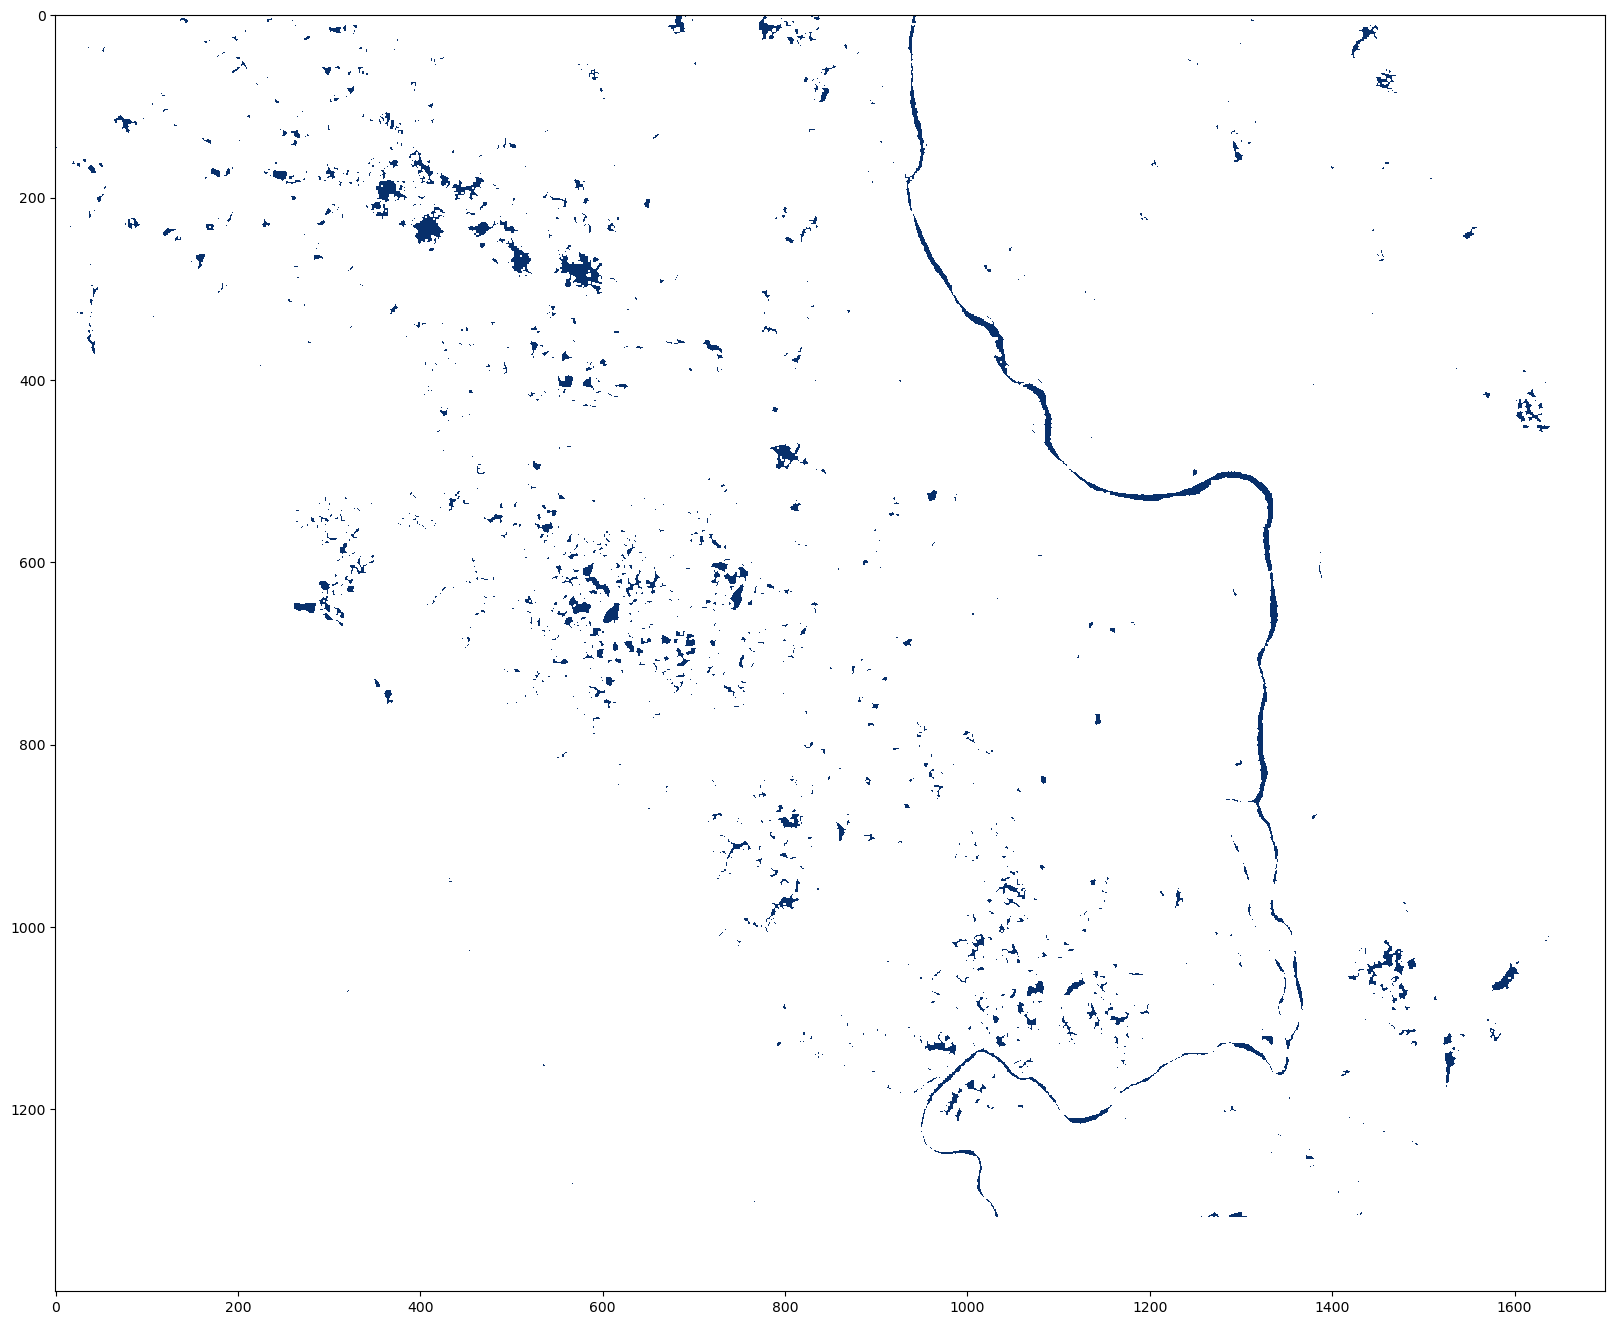

In [34]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

ar = xr.open_dataset('Dataset/Tripura/Center/Water_Masks/20171011_VV_water_mask.tiff').band_data.values[0]
plt.figure(figsize=(20,20))
plt.imshow(ar, vmin = 0, vmax = 1, cmap = 'Blues', interpolation = None)

In [8]:
xr.open_dataset('Dataset/Tripura/RTC_GAMMA_Tripura_tiffs/S1A_IW_20171023T235534_DVP_RTC30_G_gpufem_32DC_VV.tif').band

<xarray.Dataset>
Dimensions:      (band: 1, x: 9675, y: 7783)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.686e+04 5.69e+04 ... 3.471e+05 3.471e+05
  * y            (y) float64 2.825e+06 2.825e+06 ... 2.592e+06 2.592e+06
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...